In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import matplotlib as pl
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
submission_data = pd.read_csv('/home/alex/Загрузки/submissions_data_train.zip')
events_data = pd.read_csv('/home/alex/Загрузки/event_data_train.zip')

In [3]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')

In [4]:
events_data['day'] = events_data.date.dt.date
submission_data['day'] = submission_data.date.dt.date

In [5]:
#events_data
submission_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


<AxesSubplot:>

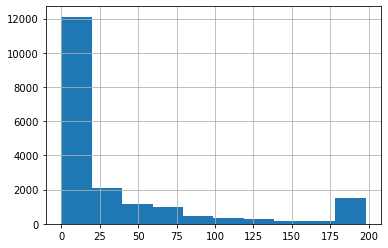

In [6]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [7]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [8]:
now = 1526772811
drop_out_treshold = 2592000

In [9]:
users_data['is_gone_user'] = now - users_data.last_timestamp > drop_out_treshold

In [10]:
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [11]:
user_scores = submission_data.pivot_table(index='user_id',
                                          columns='submission_status',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index()

In [12]:
user_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [13]:
users_data = users_data.merge(user_scores, how='outer', on='user_id')

In [14]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [15]:
users_data = users_data.fillna(0)

In [16]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [17]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [18]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [19]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [20]:
users_data = users_data.merge(users_events_data, how='outer')

In [21]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [22]:
users_data = users_data.merge(users_days, how='outer')

In [23]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [24]:
#Variate param to change n of solved steps
param = 170

In [25]:
users_data['passed_cource'] = users_data.passed > param

In [26]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_cource
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [27]:
users_data.groupby('passed_cource').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_cource,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [28]:
100*1425/17809

8.001572238755685

In [29]:
events_data_train = pd.DataFrame()

In [30]:
#events_data_train = events_data[events_data.user_id]

In [31]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [32]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'})\
    .rename({'timestamp':'min_timestamp'}, axis=1)

In [33]:
learning_time_threshold = 3*24*60*60

In [34]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [35]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [36]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [37]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [38]:
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [39]:
events_data = events_data.merge(user_min_time[['user_id','user_learning_time_threshold']], how='outer')

In [40]:
events_data.shape

(3480703, 8)

In [41]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [42]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [43]:
submission_data['user_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id','user_learning_time_threshold']], how='outer')
submission_data_train = submission_data[submission_data.user_time <= submission_data.user_learning_time_threshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

In [44]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

In [45]:
step_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename({'step_id':'steps_tried'})

In [46]:
X = X.merge(step_tried, on='user_id',how='outer')

In [47]:
X.head()

,user_id,days,step_id
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [48]:
X = X.merge(submission_data_train.pivot_table(index='user_id',
                                          columns='submission_status',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index())

In [49]:
X.head()

,user_id,days,step_id,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [50]:
X['correct_ratio'] = X.correct / (X.correct+X.wrong)

In [51]:
X.head()

,user_id,days,step_id,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [52]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()[['user_id','viewed']], how='outer')

In [53]:
X = X.fillna(0)

In [54]:
X

,user_id,days,step_id,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [55]:
X = X.merge(users_data[['user_id', 'passed_cource', 'is_gone_user']], how='outer')

In [56]:
X = X[~((X.passed_cource == False) & (X.is_gone_user==False))]

In [57]:
X

,user_id,days,step_id,correct,wrong,correct_ratio,viewed,passed_cource,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [58]:
y = X.passed_cource.map(int)

In [59]:
X = X.drop(['is_gone_user','passed_cource'],axis=1)

In [60]:
X.head()

,user_id,days,step_id,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [61]:
X = X.set_index(X.user_id)

In [62]:
X.head()

,user_id,days,step_id,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.00,9
3,3,1.0,4.0,4.0,4.0,0.50,20
8,8,1.0,11.0,9.0,21.0,0.30,154
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,23.0,23.0,27.0,0.46,132


In [63]:
X

,user_id,days,step_id,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.00,9
3,3,1.0,4.0,4.0,4.0,0.50,20
8,8,1.0,11.0,9.0,21.0,0.30,154
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
26774,26774,0.0,0.0,0.0,0.0,0.00,1
26781,26781,0.0,0.0,0.0,0.0,0.00,6
26788,26788,0.0,0.0,0.0,0.0,0.00,1


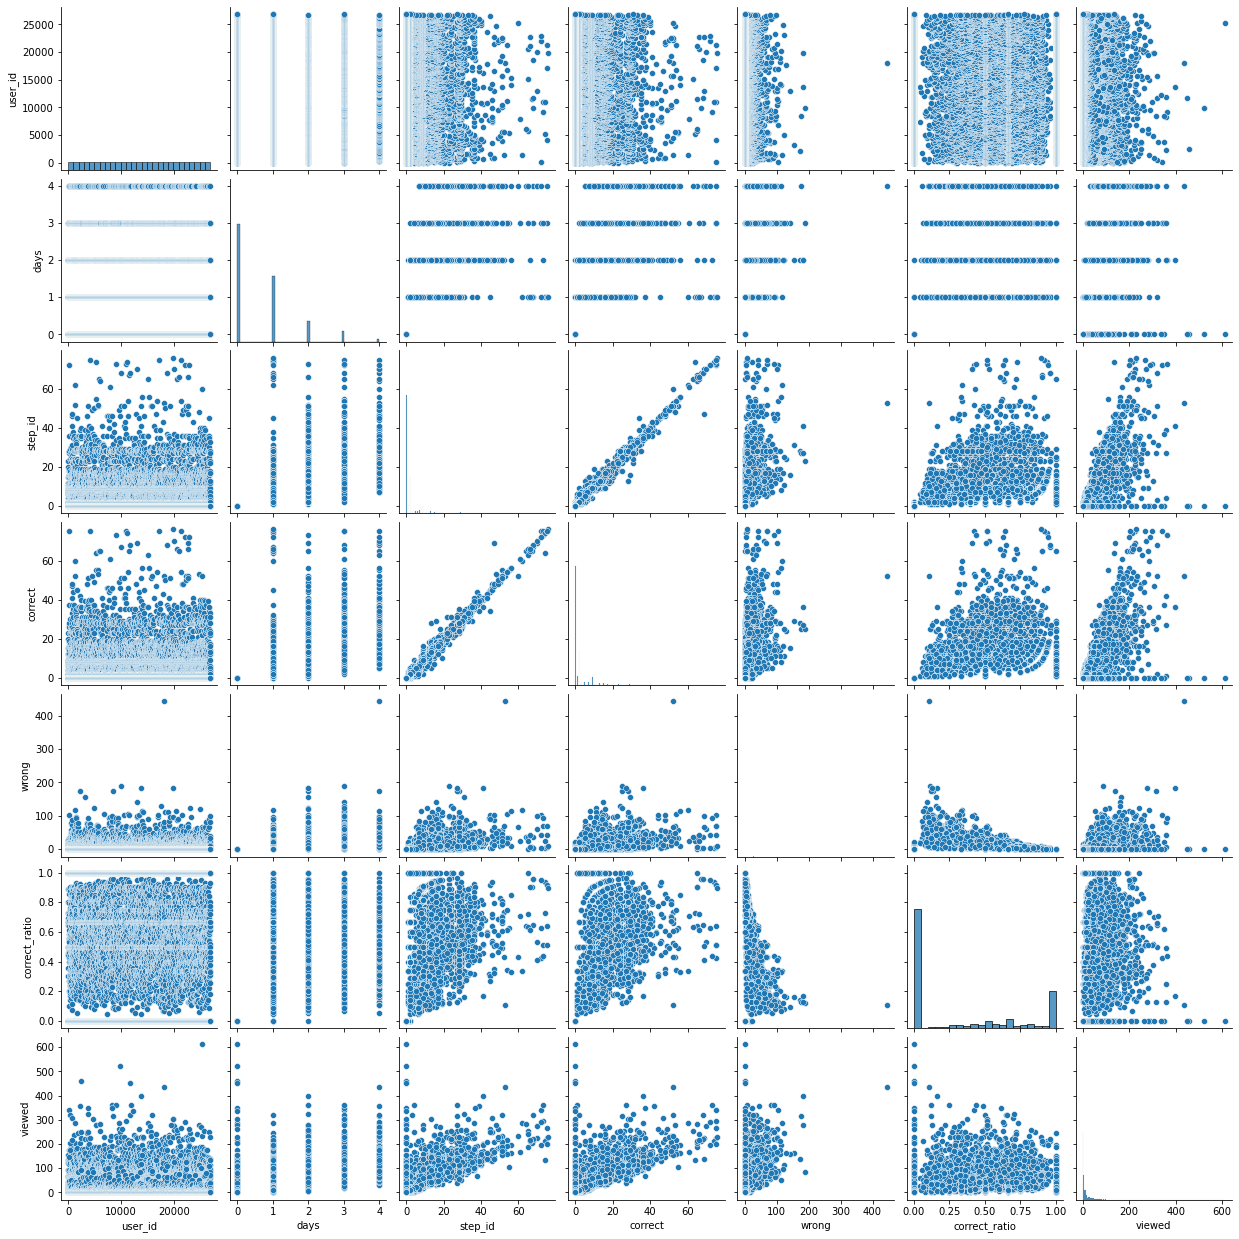

In [80]:
sns.pairplot(data=X)

In [64]:
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_cource, Length: 17985, dtype: int64

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=42)

In [66]:
ch_params = {'n_estimators':range(1,10, 3), 'max_depth':range(3,12, 3)}

In [67]:
clf_rf = RandomForestClassifier()

In [68]:
clf = RandomizedSearchCV(estimator=clf_rf, param_distributions=ch_params, random_state=0)

In [69]:
clf.fit(X_train,y_train)

/home/alex/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(3, 12, 3),
                                        'n_estimators': range(1, 10, 3)},
                   random_state=0)

In [70]:
clf_finall_rf = clf.best_estimator_

In [71]:
clf_finall_rf

RandomForestClassifier(max_depth=3, n_estimators=7)

In [72]:
predict = clf_finall_rf.predict(X_test)

In [73]:
accuracy_score(y_test,predict)

0.9314353099730458

In [74]:
Knn = KNeighborsClassifier()
clf_knn = RandomizedSearchCV(Knn, param_distributions={"n_neighbors":range(1,20,3), 'leaf_size':range(10,100,9)},
                            scoring="accuracy")

In [75]:
clf_finall_knn = clf_knn.fit(X_train,y_train)

In [76]:
clf_finall_knn = clf_finall_knn.best_estimator_

In [77]:
pred_knn = clf_finall_knn.predict(X_test)
accuracy_score(y_test, pred_knn)

0.9282345013477089

In [89]:
clf_finall_rf.feature_importances_.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

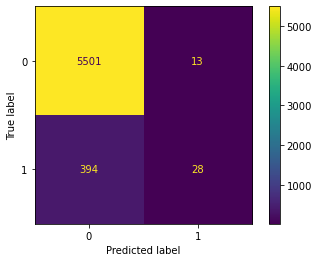

In [84]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predict)).plot()

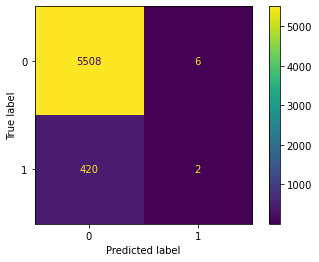

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_knn)).plot()